<a href="https://colab.research.google.com/github/devika-28/Optimal-Brain-Damage/blob/main/foundry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports
! pip uninstall -y tensorflow
! pip uninstall -y tf-nightly
! pip install -U tf-nightly-gpu
! pip install tensorflow-model-optimization

import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from keras.datasets import mnist
import tensorflow as tf
import tensorflow.keras.models as tfmodels
from numpy import linalg as LA


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# Normalize the input image so that each pixel value is between 0 and 1.
train_images = X_test / 255.0
test_images = X_test / 255.0

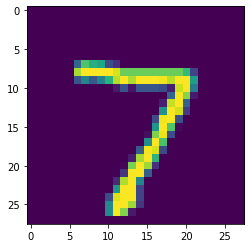

In [4]:
plt.imshow(X_test[0])

In [5]:
y_test[0]

7

In [6]:
# class Model(torch.nn.Module):

#     def __init__(self):
#         super(Model, self).__init__()

#         self.linear1 = torch.nn.Linear(1000, 1000)
#         self.linear2 = torch.nn.Linear(1000, 500)
#         self.linear3 = torch.nn.Linear(500, 500)
#         self.linear4 = torch.nn.Linear(500, 200)
#         self.activation = torch.nn.ReLU()
#         self.softmax = torch.nn.Softmax()

#     def forward(self, x):
#         x = self.linear1(x)
#         x = self.activation(x)
#         x = self.linear2(x)
#         x = self.activation(x)
#         x = self.linear3(x)
#         x = self.activation(x)
#         x = self.linear4(x)
#         x = self.softmax(x)
#         return x

# model = TinyModel()

In [7]:
def my_mnist_model():
  model = keras.Sequential()
  # model.add(tf.keras.layers.Flatten)
  model.add(tf.keras.layers.Dense(1000, activation='ReLU', input_shape=(28*28,))),
  model.add(tf.keras.layers.Dense(1000, activation = "ReLU"))
  model.add(tf.keras.layers.Dense(500, activation = "ReLU"))
  model.add(tf.keras.layers.Dense(200, activation = "ReLU"))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  return model

In [8]:
model = my_mnist_model()

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              785000    
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 500)               500500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 10)                2010      
                                                                 
Total params: 2,388,710
Trainable params: 2,388,710
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Creating Model.
X_train = X_train.reshape(X_train.shape[0], 28*28,1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28*28,1).astype('float32')
X_train/=255 #RGB
X_test/=255 #RGB
model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
y_train.shape

(60000,)

In [12]:
model.fit(X_train,y_train, batch_size=64, epochs=10)

Epoch 1/10
938/938 [==============================] - 7s 6ms/step - loss: 0.2045 - accuracy: 0.9383
Epoch 2/10
938/938 [==============================] - 8s 9ms/step - loss: 0.0939 - accuracy: 0.9724
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0642 - accuracy: 0.9807
Epoch 4/10
938/938 [==============================] - 5s 6ms/step - loss: 0.0532 - accuracy: 0.9837
Epoch 5/10
938/938 [==============================] - 5s 6ms/step - loss: 0.0425 - accuracy: 0.9869
Epoch 6/10
938/938 [==============================] - 5s 6ms/step - loss: 0.0367 - accuracy: 0.9892
Epoch 7/10
938/938 [==============================] - 5s 6ms/step - loss: 0.0327 - accuracy: 0.9908
Epoch 8/10
938/938 [==============================] - 5s 6ms/step - loss: 0.0275 - accuracy: 0.9924
Epoch 9/10
938/938 [==============================] - 5s 6ms/step - loss: 0.0264 - accuracy: 0.9925
Epoch 10/10
938/938 [==============================] - 5s 6ms/step - loss: 0.0230 - accuracy: 0.9934

In [13]:
loss, accuracy =  model.evaluate(X_test, y_test)
print("Loss", loss, "accuracy", accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.1042 - accuracy: 0.9759
Loss 0.10416281968355179 accuracy 0.9758999943733215


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              785000    
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 500)               500500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 10)                2010      
                                                                 
Total params: 2,388,710
Trainable params: 2,388,710
Non-trainable params: 0
_________________________________________________________________


#Pruning

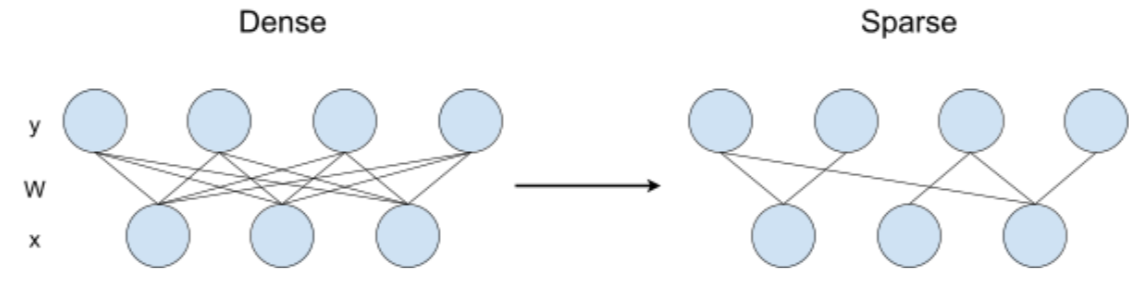

Weight Pruning:<br>
Using an L1 norm of the weight of all the filters in the network, ranking them. This is followed by pruning the ‘n’ lowest ranking filters globally.

Unit Pruning:<br>
Structured pruning; Use set of particle filters. which are the same in number as the number of convolutional filters in the network.


In [15]:
class Pruning():

    def do_weight_pruning(self,sparsity, weight, bias):
      """
      Take sparsity percentage, weight and bias, and return the update weight and biases after weight pruning   
      Args:
        sparsity: How much sparseity you want to introduce in your model
        weight: weight matrix. 
        bias: Bias array
      Returns:
        weight: new weight matrix, with initial configuration, and the pruned weights set to 0
        bias: bias array, with initial configuration
      """
      # getting the number of weights to set to 0
      setzero = int(len(weight)*sparsity)

      # L1 norm of kernel weight and sorting them in asc order and fetching their loc
      sortedL1 = np.argsort(LA.norm(weight, axis=0))
    
      #Setting the weights to 0
      weight[:,sortedL1[0:setzero]] = 0

      #Setting the bias to 0          
      bias[sortedL1[0:setzero]] = 0.
      
      return weight, bias


    def do_unit_pruning(self,sparsity, weight, bias):
      """
      Take sparsity percentage, weight and bias, and return the update weight and biases after unit pruning   
      Args:
        sparsity: How much sparseity you want to introduce in your model
        weight: weight matrix. 
        bias: Bias array
      Returns:
        weight: new weight matrix, with initial configuration, and the pruned weights set to 0
        bias: bias array, with initial configuration
      """
      # Sort absolute value of weight and get them in asc order in idx_weight
      idx_weight = np.unravel_index(np.argsort(np.abs(weight),axis=None),weight.shape)
      
      # Sort absolute value of bias and get them in asc order in idx_bias
      idx_bias = np.unravel_index(np.argsort(np.abs(bias),axis=None), bias.shape)
          
      # Number of indices to prune
      setzero = int(len(idx_weight[0])*sparsity)
      
      # Setting weight to 0 for pruned indices
      weight[(idx_weight[0][0:setzero], idx_weight[1][0:setzero])] = 0.
          
      # Set bias to 0 for pruned indices
      bias[(idx_bias[0][0:setzero])] = 0.
      
      return weight, bias


    def optimal_brain_damage(self,model, sparsity, unit=False):
        """
        Take a model made of dense layers and prunes the weights
        Args:
          model: pretrained keras model
          sparsity: How much sparsity is needed
          unit: Takes argument True for unit pruning
        Returns:
          sparse_pruned model with sparsity k%
        """

        pruned= tfmodels.clone_model(model)
        weights = model.get_weights()
        updatedWeight = []
        #not pruning the weights leading to the output logits.
        for i in range(0, len(weights)-2, 2):
            if unit:
                weight, bias = self.do_unit_pruning(sparsity, weights[i], weights[i+1])
            elif not unit:
                weight, bias = self.do_weight_pruning(sparsity, weights[i], weights[i+1])
            else:
                print("takes boolean arg for unit param")
            
            updatedWeight.append(weight)
            updatedWeight.append(bias)


        #add remaining 2 layers
        for i in range(len(weights)-2, len(weights)):
          updatedWeight.append(np.copy(weights[i]))

        # print(np.array(updatedWeight))
        # return updatedWeight
        pruned.set_weights(updatedWeight)
        return pruned


In [16]:
#Given K=[0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
#Converting to percentage
k= np.divide([0, 25, 50, 60, 70, 80, 90, 95, 97, 99], 100)

In [17]:
#Plots
loss_unit, loss_weight = [],[]
acc_unit, acc_weight = [],[]

In [18]:
prune = Pruning()
for sparsity in k:
  print("Sparsity:", int(sparsity*100))
  newModel = prune.optimal_brain_damage(model, sparsity, unit=True )
  newModel.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  score = newModel.evaluate(X_test,y_test)
  # print(score)
  loss_unit.append(score[0])
  acc_unit.append(score[1])
  print("_"*90)

Sparsity: 0
313/313 [==============================] - 1s 4ms/step - loss: 0.1042 - accuracy: 0.9759
__________________________________________________________________________________________
Sparsity: 25
313/313 [==============================] - 2s 4ms/step - loss: 0.1014 - accuracy: 0.9769
__________________________________________________________________________________________
Sparsity: 50
313/313 [==============================] - 2s 6ms/step - loss: 0.0931 - accuracy: 0.9759
__________________________________________________________________________________________
Sparsity: 60
313/313 [==============================] - 2s 6ms/step - loss: 0.0895 - accuracy: 0.9757
__________________________________________________________________________________________
Sparsity: 70
313/313 [==============================] - 2s 6ms/step - loss: 0.0961 - accuracy: 0.9737
__________________________________________________________________________________________
Sparsity: 80
313/313 [==============

In [19]:
prune = Pruning()
for sparsity in k:
  print("Sparsity:", int(sparsity*100))
  newModel = prune.optimal_brain_damage(model, sparsity, unit=False )
  newModel.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  score = newModel.evaluate(X_test,y_test)
  # print(score)
  loss_weight.append(score[0])
  acc_weight.append(score[1])
  print("_"*90)

Sparsity: 0
313/313 [==============================] - 1s 4ms/step - loss: 0.1042 - accuracy: 0.9759
__________________________________________________________________________________________
Sparsity: 25
313/313 [==============================] - 1s 4ms/step - loss: 0.0980 - accuracy: 0.9726
__________________________________________________________________________________________
Sparsity: 50
313/313 [==============================] - 1s 4ms/step - loss: 2.3092 - accuracy: 0.0974
__________________________________________________________________________________________
Sparsity: 60
313/313 [==============================] - 1s 4ms/step - loss: 2.3092 - accuracy: 0.0974
__________________________________________________________________________________________
Sparsity: 70
313/313 [==============================] - 1s 4ms/step - loss: 2.3092 - accuracy: 0.0974
__________________________________________________________________________________________
Sparsity: 80
313/313 [==============

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


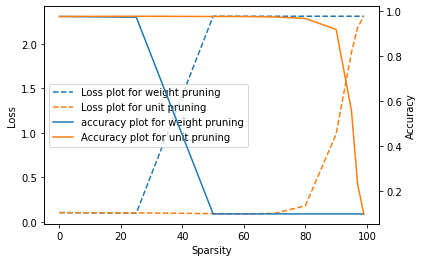

In [20]:
plt.figure()
plt.xlabel("Sparsity")
ax1 = plt.subplot()
ax1.set_ylabel("Loss")
l1 = ax1.plot(k*100,loss_weight, '--', label="Loss plot for weight pruning")
l2 = ax1.plot(k*100,loss_unit, '--', label="Loss plot for unit pruning")
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy")
l3 = ax2.plot(k*100,acc_weight, label="accuracy plot for weight pruning")
l4 = ax2.plot(k*100,acc_unit, label="Accuracy plot for unit pruning")
lines = l1+l2+l3+l4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center left')
plt.show()